In [1]:
# Import libraries necessary for this project
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping
import math
import random

Using TensorFlow backend.


In [2]:
#import dataset
fundamentals_dataset =  pd.read_csv('./datasets/fundamentals.csv', header=0)
prices_dataset =  pd.read_csv('./datasets/prices-split-adjusted.csv', header=0)
securities_dataset =  pd.read_csv('./datasets/securities.csv', header=0)

## Data Exploration

First, I'll make a cursory investigation about S&P 500 datasets. It'll help me better understand about data and problem.  
I'll use visualization and calculate statistics about dataset.

In [46]:
prices_dataset.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
## check if nan exists
prices_dataset.isnull().values.any()

False

In [5]:
# helper function to plot prices.
def plot_close_prices_by_symbol(symbol, data):
    data_by_symbol = data[data['symbol']==symbol]
    close_prices = data_by_symbol.close.values.astype('float32')
    plt.plot(close_prices)

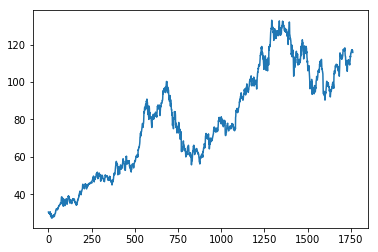

In [6]:
%matplotlib inline
## visualize Apple's stock prices
plot_close_prices_by_symbol('AAPL', prices_dataset)

In [7]:
all_company_prices = prices_dataset['close']
minimum_price = np.min(all_company_prices)
maximum_price = np.max(all_company_prices)
mean_price = np.mean(all_company_prices)
median_price = np.median(all_company_prices)
std_price = np.std(all_company_prices)

# Show the calculated statistics
print "Statistics for S&P 500 datasets:\n"
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for S&P 500 datasets:

Minimum price: $1.59
Maximum price: $1,578.13
Mean price: $65.01
Median price $48.48
Standard deviation of prices: $75.20


[462  26   5   5   0   1   1   0   0   1]


symbol
CB      0.0
CHTR    0.0
SNI     0.0
VRTX    0.0
Name: volume, dtype: float64

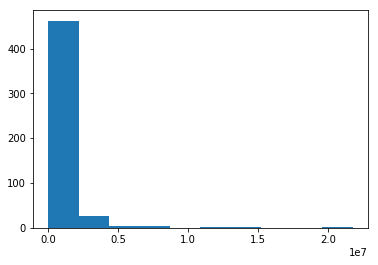

In [55]:
## check if zero volume exists
min_company_volumes = prices_dataset.groupby('symbol')['volume'].min()
plt.hist(min_company_volumes.values)

hist, bin_edges = np.histogram(min_company_volumes.values, bins=10)
print hist

[422  64   8   1   1   4   0   0   0   1]


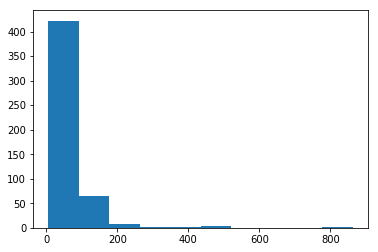

In [8]:
## check if outlier company exists
mean_company_prices = prices_dataset.groupby('symbol')['close'].mean()
plt.hist(mean_company_prices.values)

hist, bin_edges = np.histogram(mean_company_prices.values, bins=10)
print hist

[  3   4   4   0   6  14   0   0   1 469]
1762


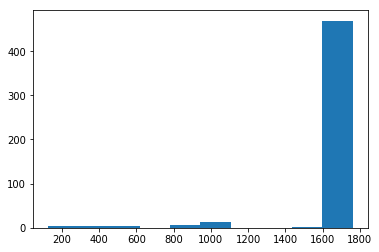

In [9]:
## check if young company exists
company_history = prices_dataset.groupby('symbol')['close'].count()
plt.hist(company_history.values)

hist, bin_edges = np.histogram(company_history.values, bins=10)
print hist
max_history = company_history.max()
print max_history

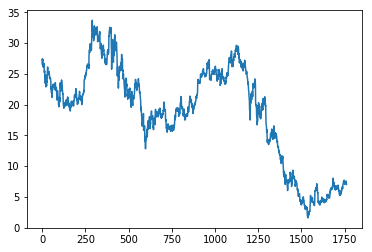

In [10]:
%matplotlib inline
## Visualize prices of company that has min price.
min_company_symbol = prices_dataset[prices_dataset['close']==minimum_price]['symbol'].values[0]
plot_close_prices_by_symbol(min_company_symbol, prices_dataset)

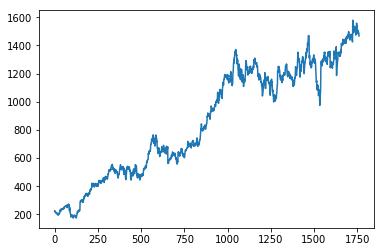

In [11]:
%matplotlib inline
## Visualize prices of company that has max price.
max_company_symbol = prices_dataset[prices_dataset['close']==maximum_price]['symbol'].values[0]
plot_close_prices_by_symbol(max_company_symbol, prices_dataset)

## Preprocessing
Before building models, I have to do data preprocessing.  
Based on the results of Data Exploration, Based on the results of Data Exploration, I determined to exclude outliers and young companies.

In [57]:
## exclude outliers, young company, zero volume.
excluded_outlier_df = pd.DataFrame({'symbol':mean_company_prices[mean_company_prices < 600].index})
excluded_young_df = pd.DataFrame({'symbol':company_history[company_history == max_history].index})
excluded_zerovolume_df = pd.DataFrame({'symbol':min_company_volumes[min_company_volumes > 0].index})

excluded_outlier_dataset = pd.merge(prices_dataset, excluded_outlier_df, on='symbol')
excluded_yound_dataset = pd.merge(excluded_outlier_dataset, excluded_young_df, on='symbol')
excluded_dataset = pd.merge(excluded_yound_dataset, excluded_zerovolume_df, on='symbol')

all_company_prices = excluded_dataset['close']
minimum_price = np.min(all_company_prices)
maximum_price = np.max(all_company_prices)
mean_price = np.mean(all_company_prices)
median_price = np.median(all_company_prices)
std_price = np.std(all_company_prices)

# Show the calculated statistics
print "Statistics for S&P 500 datasets:\n"
print "Number of company: {:,d}".format(excluded_dataset.groupby('symbol')['close'].apply(list).count())
print "Minimum price: ${:,.2f}".format(minimum_price)
print "Maximum price: ${:,.2f}".format(maximum_price)
print "Mean price: ${:,.2f}".format(mean_price)
print "Median price ${:,.2f}".format(median_price)
print "Standard deviation of prices: ${:,.2f}".format(std_price)

Statistics for S&P 500 datasets:

Number of company: 463
Minimum price: $1.59
Maximum price: $844.36
Mean price: $63.47
Median price $48.33
Standard deviation of prices: $64.15


In [58]:
sample_company_num = 50
seed = 42
excluded_indexes = excluded_dataset.groupby('symbol').count().index.values
random.seed(seed)
random.shuffle(excluded_indexes)
sample_indexes = excluded_indexes[:sample_company_num]
sampled_company_df = pd.DataFrame({'symbol':sample_indexes})
sampled_dataset = pd.merge(excluded_dataset, sampled_company_df, on='symbol')

## Build benchmark models

In [59]:
# use 25 timesteps to predict next 1 time step.
use_time_steps = 25
predict_time_steps = 1

In [60]:
# create training and testing dataset.
train_ratio = 0.7
train_size = int(max_history * train_ratio)
test_size = max_history - train_size

company_prices = sampled_dataset.groupby('symbol')['close'].apply(list)
company_prices_train = company_prices.apply(lambda x : x[0:train_size])
company_prices_test = company_prices.apply(lambda x : x[train_size:max_history])

In [61]:
## function to create training dataset.
def create_dataset(dataset, time_steps= 1):  
    dataX, dataY = [], []
    for i in range(len(dataset) - time_steps - 1):
        a = dataset[i : (i + time_steps)]
        dataX.append(a)
        dataY.append(dataset[i + time_steps])
    return np.array(dataX), np.array(dataY)

In [62]:
# helper function to build benchmark models.
def calc_rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

def get_prediction_result(row, pred_func, time_steps):
    x, y = create_dataset(row, time_steps)
    predicted = pred_func(x)
    return np.array([y, predicted])

In [90]:
# Benchmark1 : the model outputs the historical mean value.
predict_benchmark1 = lambda x : np.mean(x, axis = 1)
benchmark1_res = company_prices_test.apply(lambda x : get_prediction_result(x, predict_benchmark1, use_time_steps))
benchmark1_rmse = benchmark1_res.apply(lambda x : calc_rmse(x[0, :], x[1, :]))
benchmark1_total_rmse = np.mean(benchmark1_rmse)
print "RMSE of Benchmark 1: {:,.4f}".format(benchmark1_total_rmse)

RMSE of Benchmark 1: 3.7676


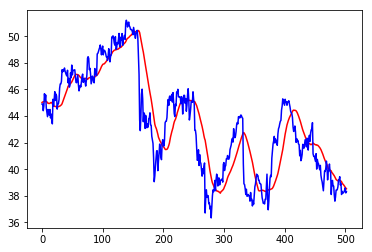

In [91]:
# visualize output of benchmark model 1.
plt.plot(benchmark1_res[0][1, :],color='red', label='Prediction')
plt.plot(benchmark1_res[0][0, :], color='blue', label='Actual')
plt.show()

In [92]:
# Benchmark2 : the model outputs the very last observation out.
predict_benchmark2 = lambda x : x[:, -1]
benchmark2_res = company_prices_test.apply(lambda x : get_prediction_result(x, predict_benchmark2, use_time_steps))
benchmark2_rmse = benchmark2_res.apply(lambda x : calc_rmse(x[0, :], x[1, :]))
benchmark2_total_rmse = np.mean(benchmark2_rmse)
print "RMSE of Benchmark 2: {:,.4f}".format(np.mean(benchmark2_total_rmse))

RMSE of Benchmark 2: 1.3575


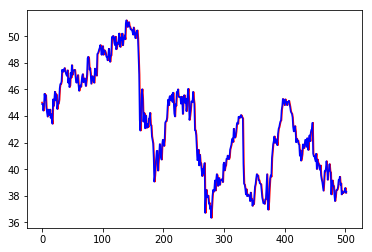

In [93]:
# visualize output of benchmark model 2.
plt.plot(benchmark2_res[0][1, :],color='red', label='Prediction')
plt.plot(benchmark2_res[0][0, :], color='blue', label='Actual')
plt.show()

## Build LSTM Model

In [103]:
# Build Simple LSTM Model
def build_simple_lstm_model(layers):
    model = Sequential()

    model.add(LSTM(512, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(0.2))

    #model.add(LSTM(256 ,return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(LSTM(512))
    model.add(Dropout(0.2))
    
    model.add(Dense(layers[2],init="uniform",activation='linear'))
    
    model.compile(loss="mse", optimizer="adam")
    return model

In [104]:
# create training and testing dataset. df is required to contain single company. df's last column is require to be y.
def create_train_test_dataset(df, time_steps, split=0.8):
    amount_of_features = len(df.columns)
    data = df.as_matrix() 
    time_steps += 1
    result = []
    
    for index in range(len(data) - time_steps):
        result.append(data[index: index + time_steps])
    
    result = np.array(result)
    row = int(round(split * result.shape[0]))
    train = result[:int(row), :]
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[row:, :-1] 
    y_test = result[row:, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return x_train, y_train, x_test, y_test

In [105]:
x_train, y_train, x_test, y_test = [], [], [], []
company_symbols = sampled_dataset.groupby("symbol").count().index.values
for company_symbol in company_symbols:
    company_df = sampled_dataset[sampled_dataset.symbol == company_symbol][['open', 'low', 'high', 'volume', 'close']]
    x_train_tmp, y_train_tmp, x_test_tmp, y_test_tmp = create_train_test_dataset(company_df, use_time_steps)
    x_train.extend(x_train_tmp)
    y_train.extend(y_train_tmp)
    x_test.extend(x_test_tmp)
    y_test.extend(y_test_tmp)

In [106]:
# それぞれ対数変換 + 標準化
x_train_log, y_train_log, x_test_log, y_test_log = np.log(x_train), np.log(y_train), np.log(x_test), np.log(y_test)

In [107]:
x_train_normalize_values = np.apply_along_axis(lambda x : np.full(x.shape[0], x[0]), 1, x_train_log)
y_train_normalize_values = np.apply_along_axis(lambda x : x[0], 1, x_train_log)
x_test_normalize_values = np.apply_along_axis(lambda x : np.full(x.shape[0], x[0]), 1, x_test_log)
y_test_normalize_values = np.apply_along_axis(lambda x : x[0], 1, x_test_log)

In [108]:
x_train_preprocessed = x_train_log / x_train_normalize_values - 1
y_train_preprocessed = y_train_log / y_train_normalize_values[:, -1] - 1
x_test_preprocessed = x_test_log / x_test_normalize_values - 1
y_test_preprocessed = y_test_log / y_test_normalize_values[:, -1] - 1

In [109]:
epochs = 20
model = build_simple_lstm_model([5, use_time_steps, 1])
early_stopping = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='auto')    
hist = model.fit(x_train_preprocessed, y_train_preprocessed, callbacks=[early_stopping], batch_size=512, nb_epoch=epochs, validation_split=0.15, shuffle=True, verbose=1)

Train on 59032 samples, validate on 10418 samples
Epoch 1/20
59032/59032 [==============================] - 37s - loss: 7.6090e-05 - val_loss: 4.9847e-05

In [87]:
trainScore = model.evaluate(x_train_preprocessed, y_train_preprocessed, verbose=1)
testScore = model.evaluate(x_test_preprocessed, y_test_preprocessed, verbose=1)
print('Train Score: %.5f MSE (%.5f RMSE)' % (trainScore, math.sqrt(trainScore)))
print('Test Score: %.5f MSE (%.5f RMSE)' % (testScore, math.sqrt(testScore)))

17350/17350 [==============================] - 11s     

In [110]:
predict = model.predict(x_test_preprocessed, verbose=1)

17350/17350 [==============================] - 16s      

In [111]:
# re-normalized
predict_renormalized = (predict.reshape(predict.shape[0]) + 1) * y_test_normalize_values[:, -1]
predict_renormalized = np.exp(predict_renormalized)

In [112]:
actuals = []
predicts = []
rmses = []
data_per_company = predict.shape[0] / sample_company_num
for i in range(sample_company_num):
    start_index = i * data_per_company
    end_index = (i + 1) * (data_per_company)
    company_name = company_prices_test.index[i]
    lstm_rmse = calc_rmse(y_test[start_index:end_index], predict_renormalized[start_index:end_index].reshape(data_per_company))
    actuals.append(y_test[start_index:end_index])
    predicts.append(predict_renormalized[start_index:end_index].reshape(data_per_company))
    rmses.append(lstm_rmse)
    print('Test Score: index%d company %s RMSE %.2f RMSE_bench %.2f mean %.2f' % (i, company_name, lstm_rmse, benchmark2_rmse[i], np.mean(actuals[i])))
print('Total Test Score: %.5f RMSE' % np.mean(rmses))

Test Score: index0 company ABT RMSE 0.74 RMSE_bench 0.62 mean 41.51
Test Score: index1 company ADBE RMSE 1.58 RMSE_bench 1.33 mean 94.36
Test Score: index2 company ADI RMSE 1.12 RMSE_bench 1.04 mean 59.51
Test Score: index3 company ADP RMSE 1.07 RMSE_bench 0.97 mean 87.54
Test Score: index4 company AMG RMSE 3.80 RMSE_bench 3.21 mean 155.42
Test Score: index5 company AYI RMSE 4.93 RMSE_bench 3.86 mean 232.52
Test Score: index6 company BDX RMSE 2.08 RMSE_bench 1.79 mean 158.52
Test Score: index7 company CCL RMSE 0.94 RMSE_bench 0.81 mean 49.20
Test Score: index8 company CERN RMSE 1.02 RMSE_bench 0.95 mean 58.05
Test Score: index9 company CF RMSE 1.20 RMSE_bench 1.10 mean 34.23
Test Score: index10 company CHD RMSE 0.59 RMSE_bench 0.49 mean 45.67
Test Score: index11 company CHRW RMSE 0.95 RMSE_bench 0.93 mean 70.10
Test Score: index12 company CI RMSE 2.40 RMSE_bench 2.28 mean 134.22
Test Score: index13 company CSX RMSE 0.53 RMSE_bench 0.49 mean 27.90
Test Score: index14 company DNB RMSE 1.

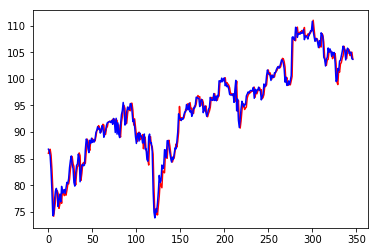

In [38]:
plt.plot(predicts[0],color='red', label='Prediction')
plt.plot(actuals[0], color='blue', label='Actual')
plt.show()